In [4]:
# constants

pnames = ["Nose",#0
          "Neck",#1 
          "RShoulder",#2 
          "RElbow", #3
          "RWrist", #4
          "LShoulder",#5
          "LElbow",#6
          "LWrist",#7
          "RHip",#8
          "RKnee",#9
          "RAnkle",#10
          "LHip",#11
          "LKnee",#12
          "LAnkle",#13
          "REye",#14
          "LEye",#15
          "REar",#16
          "LEar",#17
          "Bkg"]#18

# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

In [30]:
from cStringIO import StringIO
import numpy as np
import PIL.Image
from IPython.display import clear_output, Image, display
from scipy.misc import imresize

# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
# caffe.set_mode_gpu()
# caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg', resize=True, height=360, width=360):
    a = np.uint8(np.clip(a, 0, 255))
    a = imresize(a, [height, width], 'bilinear')
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [6]:
import json
import cv2 as cv
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import glob

NUM_TOTAL_JOINTS = 18

class Body:

    """ representing one body with joints info """
    def __init__(self, joints_raw, parts_thresh = 0.0, conf_thresh=0.0, min_size_thresh=0):
        """ initializing with joints array 
        
        parts_thresh: (visible joints/total joints). 
                    body with the number of valid joints under this threshold will be regarded as invalid
        conf_thresh: joints with confidence under this threshold will be ignored
        min_size_thresh: max(body width, body height) should be bigger than this threshold
        """
        assert len(joints_raw) == 54, "Invlid joint array"
        self.joints_raw = joints_raw
        self.joints = []
        self.parts_thresh = parts_thresh
        self.conf_thresh = conf_thresh
        self.num_joints_valid = 0
    
        # create joints array
        for i in range(0,len(joints_raw), 3):
            self.joints.append(joints_raw[i:i+3])
            if joints_raw[i+2] > conf_thresh:
                self.num_joints_valid += 1
        self.joints_array = self.joints # keep this for convenience
        self.joints = np.array(self.joints)
        
        if self.num_joints_valid / float(NUM_TOTAL_JOINTS) < parts_thresh:
            self.is_valid = False
            return
        
        # get size
        _joints = []
        for _j in self.joints_array:
            if _j[2] > self.conf_thresh:
                _joints.append(_j[:2]) # ignore invalid joint
        _joints = np.array(_joints)
        min_x = np.min(_joints[:,0])
        max_x = np.max(_joints[:,0]) 
        min_y = np.min(_joints[:,1])
        max_y = np.max(_joints[:,1]) 
        size  = max(max_x - min_x, max_y - min_y)
        
        # get normalized joints
        self.norm_joints = self.get_normalized_joints_matrix()

        # enough visible joints and bigger enough
        self.is_valid = (size > min_size_thresh and self.norm_joints is not None)         
        
    def is_valid_joint(self, index1, index2):
        """ check if a joint between index1 to index2 is valid 
        """
        return (self.joints_array[index1][2] > self.conf_thresh and self.joints_array[index2][2] > self.conf_thresh)
        
    def get_cropped_image_around_body(self, canvas, margin_coef = 1.25):
        """ crop image around find body
        """
        assert self.is_valid, "this body has not enough valid joints!"
        
        _joints = []
        for _j in self.joints_array:
            if _j[2] > self.conf_thresh:
                _joints.append(_j[:2])
        
        _joints = np.array(_joints)
        min_x = np.min(_joints[:,0])
        max_x = np.max(_joints[:,0]) 
        min_y = np.min(_joints[:,1])
        max_y = np.max(_joints[:,1]) 
        center = [0.5*(max_x+min_x),0.5*(max_y+min_y)]
        size  = max(max_x - min_x, max_y - min_y) * margin_coef 
          
        x1 = int(min(max(0, center[0] - size*0.5), canvas.shape[1]))
        x2 = int(min(max(0, center[0] + size*0.5), canvas.shape[1]))
        y1 = int(min(max(0, center[1] - size*0.5), canvas.shape[0]))
        y2 = int(min(max(0, center[1] + size*0.5), canvas.shape[0]))
  
        cropped = canvas[y1:y2, x1:x2]
        return cropped
    
    def get_normalized_joints_matrix(self):
        """
        normalized for learning.
        center = between left 
        """
        
        joints = np.copy(self.joints)
        
        # TODO: how to handle invalid joint???
        # at least you should have valid hips!
        if np.min(joints[(pnames.index("RHip"), pnames.index("LHip")),2]) < self.conf_thresh:
            return None;
        
        # body center is between hips
        body_center = np.mean(joints[(pnames.index("RHip"), pnames.index("LHip")),:2], axis=0)         
        
        # assume that the less confident parts are at the center of body
        joints[joints[:,2] < self.conf_thresh, :2] = body_center
        dists = joints[:, :2] - body_center        
        max_dist = np.max(np.linalg.norm(dists, axis=1))
        norm_dists = dists/max_dist
        return norm_dists
        

In [34]:
import random
from tqdm import tqdm

filepaths = glob.glob("./video/olympic_json/*.json")
random.shuffle(filepaths)

body_mat = None
body_info = []

for jsonpath in tqdm(filepaths):
    with open(jsonpath) as json_data:
        d = json.load(json_data)
        bodies = d['bodies']
        for _b in bodies:
            body = Body(_b['joints'], parts_thresh=0.60, conf_thresh=0.30, min_size_thresh=180)

            if body.is_valid:
                imagepath = "olympic_frames" +jsonpath[12:-5]+".jpg"
                
                if body_mat is None:
                    body_mat = body.norm_joints.reshape(1, 36)
                else:
                    body_mat = np.vstack((body_mat, body.norm_joints.reshape(1,36)))
                body_info.append({"image": imagepath, "body": body})

body_mat = np.array(body_mat)
print body_mat.shape
print "# of found bodies", len(body_info)


 72%|███████▏  | 390399/539856 [1:04:43<2:11:17, 18.97it/s]


KeyboardInterrupt: 

In [24]:
body_mat = np.array(body_mat)
print body_mat.shape
print "# of found bodies", len(body_info)


(141445, 36)
# of found bodies 141445


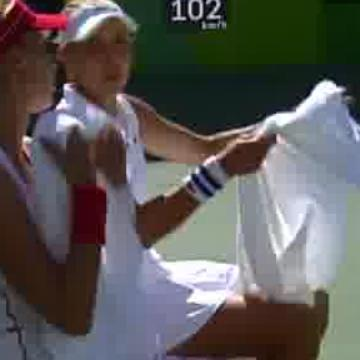

In [ ]:
import zmq
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import clear_output

port = "5555"
context = zmq.Context()
socket = context.socket(zmq.SUB)
socket.connect ("tcp://localhost:%s" % port)
socket.setsockopt(zmq.SUBSCRIBE,'') # need to set this!!!

while 1:
    message = socket.recv()
    _json = json.loads(message)
    bodies = _json['bodies']
    for _b in bodies:
        body = Body(_b['joints'], parts_thresh=0.70, conf_thresh=0.30)
        if body.is_valid:
            dist_out = euclidean_distances(body_mat, body.norm_joints.reshape(1,36))                    
            index = np.argmin(dist_out)
            imagepath = body_info[index]['image']
            foundbody = body_info[index]['body']

            canvas = cv.imread(imagepath) # B,G,R order
            cropped = foundbody.get_cropped_image_around_body(canvas, 1.30)
            showarray(cropped[:,:,[2,1,0]])
            clear_output(wait=True)

19


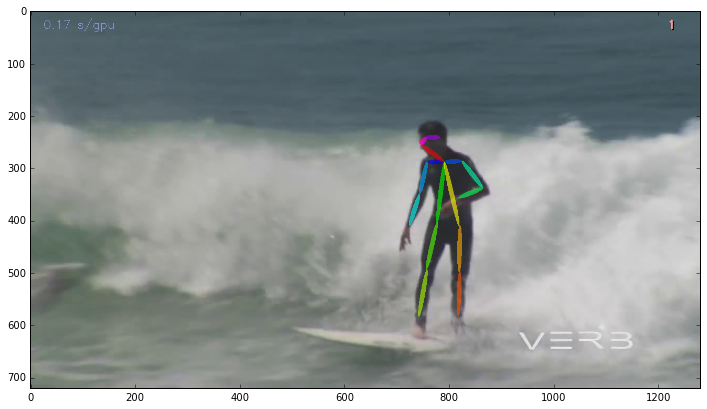

In [86]:
# visualize 2
import math
stickwidth = 4
print  len(limbSeq)
for i in range(17):
    seq = np.array(limbSeq[i]) - 1
    cur_canvas = canvas.copy()
    
    if body.is_valid_joint(seq[0].astype(int), seq[1].astype(int)):
        Y = body.joints[seq.astype(int), 0]
        X = body.joints[seq.astype(int), 1]

        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = plt.gcf()
fig.set_size_inches(12, 12)

In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances

# filepaths = glob.glob("tudor3/*.json")
# found = False
# for jsonpath in filepaths:
#     with open(jsonpath) as json_data:
#         d = json.load(json_data)
#         bodies = d['bodies']
#         if len(bodies) > 0:
#             for _b in bodies:
#                 body = Body(_b['joints'], parts_thresh=0.80, conf_thresh=0.30)
                
#                 if body.is_valid:
#                     imagepath = jsonpath[:-5]+".jpg"
#                     canvas = cv.imread(imagepath) # B,G,R order
#                     cropped = body.get_cropped_image_around_body(canvas, 1.6)
#                     showarray(cropped[:,:,[2,1,0]])
                    
#                     dist_out = euclidean_distances(body_mat, body.norm_joints.reshape(1,36))                    
#                     index = np.argmin(dist_out)
#                     imagepath = body_info[index]['image']
#                     foundbody = body_info[index]['body']

#                     canvas = cv.imread(imagepath) # B,G,R order
#                     cropped = foundbody.get_cropped_image_around_body(canvas, 1.30)
#                     showarray(cropped[:,:,[2,1,0]])
                    


In [ ]:
import glob
from tqdm import tqdm

flags = '-caffemodel ../model/coco/pose_iter_440000.caffemodel -caffeproto ../model/coco/pose_deploy_linevec.prototxt'
filepaths = glob.glob("olympics/*.mp4")
for path in tqdm(filepaths):
    filename = path[:-4]
    !../build/examples/rtpose/rtpose.bin {flags} -video {path}  -write_json {filename} -write_frames {filename} -no_display -no_joints_overlay

  0%|          | 0/303 [00:00<?, ?it/s]

^C


  0%|          | 1/303 [09:59<50:18:49, 599.77s/it]

In [ ]:
import cv2
print(cv2.__version__)
import glob
from tqdm import tqdm

filepaths = glob.glob("olympics/*.mp4")

for path in tqdm(filepaths):
    vidcap = cv2.VideoCapture(path)
    filename = path[9:-4]
    print filename
    fps = vidcap.get(cv2.cv.CV_CAP_PROP_FPS)
    desired_fps = 5
    skip_frame = int(fps/desired_fps)
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
        frameId = int(round(vidcap.get(1))) 
        success,image = vidcap.read()
        if frameId % skip_frame == 0:
            cv2.imwrite("olympics_frames/%s_%d.jpg" % (filename, frameId), image)     # save frame as JPEG file


  0%|          | 0/303 [00:00<?, ?it/s]

2.4.8
olympics_0217
